### This notebook looks at the impact of systematically deleting SC ...the INNER connectivity i.e., from ntwx A to itself, ntwx B to itself when ntwx X is isolated ...

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [2]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [3]:
from collections import Counter

In [4]:
import seaborn as sns
import scipy.stats as stats

In [5]:
import pickle

In [6]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [7]:
import re

In [8]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [9]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [10]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [11]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 1min 2s


In [12]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.42 s, sys: 0 ns, total: 1.42 s
Wall time: 1.42 s


In [13]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [14]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [15]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
    ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
    all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
    ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
    all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
    all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
    all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
    ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
    all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
    all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
    all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 2min 32s, sys: 0 ns, total: 2min 32s
Wall time: 3min 23s


In [16]:
# for now deal with avg fc of DMN lesion only (across all ntwx) ...
# This is INNER connectivity ... i.e., the average ntwx conn to itself (so Vis to Vis, DMN to DMN, etc)

# all_subs_og_whobpyt
# all_subs_dmn_lesion

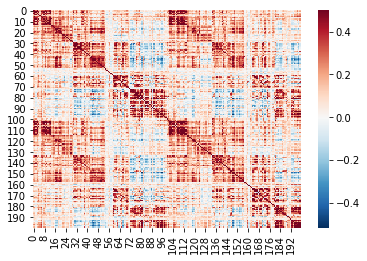

In [17]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

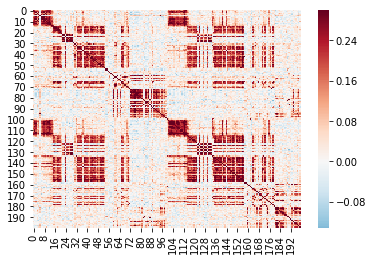

In [18]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [19]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [20]:
# corrs_list

In [21]:
# ntwx_only_lh[(ntwx_only_lh>0.1)] # & (ntwx_only_rh<0.9)

In [27]:
def ntwx_only_fc(fc, sub, a,b,c,d):
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_rh = fc[sub][c:d, c:d]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    
#     mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
#     mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2)
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh))/2 + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2
    return mean_fc

In [28]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

In [29]:
Ntwx = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

#### original whobpyt

In [43]:
%%time

# original whobpyt

org_whobpyt_vis_mean_fc_all_subs = []
org_whobpyt_sommot_mean_fc_all_subs = []
org_whobpyt_dorsattn_mean_fc_all_subs = []
org_whobpyt_ventattn_mean_fc_all_subs = []
org_whobpyt_limbic_mean_fc_all_subs = []
org_whobpyt_fpn_mean_fc_all_subs = []
org_whobpyt_dmn_mean_fc_all_subs = []

for i in range(200):
    
    temp_vis = ntwx_only_fc(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    org_whobpyt_vis_mean_fc_all_subs.append(temp_vis)
    
    temp_sommot = ntwx_only_fc(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    org_whobpyt_sommot_mean_fc_all_subs.append(temp_sommot)

    temp_dorsattn = ntwx_only_fc(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    org_whobpyt_dorsattn_mean_fc_all_subs.append(temp_dorsattn)

    temp_ventattn = ntwx_only_fc(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    org_whobpyt_ventattn_mean_fc_all_subs.append(temp_ventattn)

    temp_limbic = ntwx_only_fc(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    org_whobpyt_limbic_mean_fc_all_subs.append(temp_limbic)

    temp_fpn = ntwx_only_fc(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    org_whobpyt_fpn_mean_fc_all_subs.append(temp_fpn)

    temp_dmn = ntwx_only_fc(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    org_whobpyt_dmn_mean_fc_all_subs.append(temp_dmn)

    
    
    
org_whobpyt_vis_mean_fc_all_subs_mean = np.mean(org_whobpyt_vis_mean_fc_all_subs)
org_whobpyt_sommot_mean_fc_all_subs_mean = np.mean(org_whobpyt_sommot_mean_fc_all_subs)
org_whobpyt_dorsattn_mean_fc_all_subs_mean = np.mean(org_whobpyt_dorsattn_mean_fc_all_subs)
org_whobpyt_ventattn_mean_fc_all_subs_mean = np.mean(org_whobpyt_ventattn_mean_fc_all_subs)
org_whobpyt_limbic_mean_fc_all_subs_mean = np.mean(org_whobpyt_limbic_mean_fc_all_subs)
org_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(org_whobpyt_fpn_mean_fc_all_subs)
org_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(org_whobpyt_dmn_mean_fc_all_subs)


org_whobpyt_means = [org_whobpyt_vis_mean_fc_all_subs_mean,
org_whobpyt_sommot_mean_fc_all_subs_mean,
org_whobpyt_dorsattn_mean_fc_all_subs_mean,
org_whobpyt_ventattn_mean_fc_all_subs_mean,
org_whobpyt_limbic_mean_fc_all_subs_mean,
org_whobpyt_fpn_mean_fc_all_subs_mean,
org_whobpyt_dmn_mean_fc_all_subs_mean]

org_whobpyt_all_subs = [org_whobpyt_vis_mean_fc_all_subs,
org_whobpyt_sommot_mean_fc_all_subs,
org_whobpyt_dorsattn_mean_fc_all_subs,
org_whobpyt_ventattn_mean_fc_all_subs,
org_whobpyt_limbic_mean_fc_all_subs,
org_whobpyt_fpn_mean_fc_all_subs,
org_whobpyt_dmn_mean_fc_all_subs]

CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 126 ms


In [44]:
org_whobpyt_all_subs[0]

[0.38200159356833324,
 0.5281912323166373,
 0.5223039146353133,
 0.5790754207221558,
 0.4822468039602803,
 0.43784491741779635,
 0.48438755039108977,
 0.5852364269915822,
 0.4565704216221961,
 0.25754866032154505,
 0.5203442656041685,
 0.5449810471808242,
 0.5076365549253943,
 0.5674274830871835,
 0.3954168877438081,
 0.518481507737081,
 0.525841322804449,
 0.3071711213886651,
 0.44950938684831243,
 0.5919197414892635,
 0.5726251045001363,
 0.48676965433393915,
 0.2850313030353716,
 0.3877546857591141,
 0.45176874922519217,
 0.5555816599523957,
 0.528789013058713,
 0.5253627661168452,
 0.4414357305654413,
 0.4622989888652015,
 0.3520324147873532,
 0.4952375468084743,
 0.3150420690073869,
 0.42076016839236696,
 0.5080602359323988,
 0.5394836611676289,
 0.37264455706193994,
 0.3639986071996668,
 0.39277894062334057,
 0.5293144750975283,
 0.4519461608956753,
 0.5374659664488814,
 0.2912960218818451,
 0.5374554629653976,
 0.4166111898262657,
 0.47863866997780213,
 0.5987657699555129,
 0.45

In [32]:
ntwx_labels = ['Vis','SomMot', 'DorsAttn', 'VentAttn', 'Limbic','FPN','DMN']

In [33]:
def func_for_inner_ntwx_connectivity(all_subs_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = ntwx_only_fc(all_subs_ntwx_lesion, i, 0, 14, 100, 115)
        ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = ntwx_only_fc(all_subs_ntwx_lesion, i, 14, 30, 115, 134)
        ntwx_lesion_whobpyt_sommot_mean_fc_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 30, 43, 134, 147)
        ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 43, 54, 147, 158)
        ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = ntwx_only_fc(all_subs_ntwx_lesion, i, 54, 60, 158, 164)
        ntwx_lesion_whobpyt_limbic_mean_fc_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = ntwx_only_fc(all_subs_ntwx_lesion, i, 60, 73, 164, 181)
        ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = ntwx_only_fc(all_subs_ntwx_lesion, i, 73, 100, 181, 200)
        ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(ntwx_lesion_temp_dmn)


    ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_vis_mean_fc_all_subs)
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_sommot_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_limbic_mean_fc_all_subs)
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_fpn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dmn_mean_fc_all_subs)


    ntwx_lesion_means_all_subs = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs,ntwx_lesion_whobpyt_sommot_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs,ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_limbic_mean_fc_all_subs,ntwx_lesion_whobpyt_fpn_mean_fc_all_subs,
                                  ntwx_lesion_whobpyt_dmn_mean_fc_all_subs]
    
    ntwx_lesion_whobpyt_means = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means, ntwx_lesion_means_all_subs

In [35]:
org2_whobpyt_means, org2_all_subs = func_for_inner_ntwx_connectivity(all_subs_og_whobpyt)

In [49]:
org_whobpyt_df = pd.DataFrame(org2_all_subs,index=ntwx_labels)

org_whobpyt_df = org_whobpyt_df.T

# org_whobpyt_df

In [50]:
vis_lesion_whobpyt_means, vis_all_subs = func_for_inner_ntwx_connectivity(all_subs_vis_lesion)
sommot_lesion_whobpyt_means, sommot_all_subs = func_for_inner_ntwx_connectivity(all_subs_sommot_lesion)
dorsattn_lesion_whobpyt_means, dorsattn_all_subs = func_for_inner_ntwx_connectivity(all_subs_dorsattn_lesion)
ventattn_lesion_whobpyt_means, ventattn_all_subs = func_for_inner_ntwx_connectivity(all_subs_ventattn_lesion)
limbic_lesion_whobpyt_means, limbic_all_subs = func_for_inner_ntwx_connectivity(all_subs_limbic_lesion)
fpn_lesion_whobpyt_means, fpn_all_subs = func_for_inner_ntwx_connectivity(all_subs_fpn_lesion)
dmn_lesion_whobpyt_means, dmn_all_subs = func_for_inner_ntwx_connectivity(all_subs_dmn_lesion)

In [156]:
len(vis_all_subs)

7

In [157]:
ntwx_lesion_whobpyt_means = [vis_lesion_whobpyt_means,
sommot_lesion_whobpyt_means,
dorsattn_lesion_whobpyt_means,
ventattn_lesion_whobpyt_means,
limbic_lesion_whobpyt_means,
fpn_lesion_whobpyt_means,
dmn_lesion_whobpyt_means]

In [158]:
org2_whobpyt_means

[0.4762078600105418,
 0.3631816538835267,
 0.42919435967509484,
 0.3896369001336325,
 0.23726664629058955,
 0.25749079527721935,
 0.2609094925186768]

In [159]:
for i in range(7):
    print(ntwx_lesion_whobpyt_means[i][i])

0.44190046455038556
0.2535525146561335
0.2542934383418356
0.23884354728467672
0.21978236101049803
0.22704155143672153
0.24088748638655652


In [63]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']\

In [42]:
import statsmodels.api as sm
import pingouin as pg

In [72]:
i = 0

condition_A = org_whobpyt_all_subs[i].copy()
condition_B = vis_all_subs[i].copy()

data = []

for subject in range(1, 201):
        data.append([subject, 'A', condition_A[subject-1]])
        data.append([subject, 'B', condition_B[subject-1]])

df = pd.DataFrame(data, columns=['Subject', 'Condition', 'Dependent_Variable'])

rm_anova = pg.rm_anova(data=df, dv='Dependent_Variable', within='Condition', subject='Subject')
posthoc = pg.pairwise_ttests(data=df, dv='Dependent_Variable', within='Condition', subject='Subject', padjust='holm')

print('VIS Lesion - {0} to itself ntwx \n'.format(Ntwx_labels[i]))
print(rm_anova, '\n')
print(posthoc, '\n')
print('---------------------------------- \n')


VIS Lesion - Vis to itself ntwx 

      Source  ddof1  ddof2         F    p-unc       np2  eps
0  Condition      1    199  7.718269  0.00599  0.037337  1.0 

    Contrast  A  B  Paired  Parametric         T    dof       Tail    p-unc  \
0  Condition  A  B    True        True  2.778177  199.0  two-sided  0.00599   

    BF10    hedges  
0  3.306  0.218768   

---------------------------------- 



In [71]:
t_statistic, p_value = stats.ttest_rel(org_whobpyt_all_subs[0], vis_all_subs[0])
print(t_statistic, p_value)

2.7781772047446633 0.0059896613285814705


#### Visual lesion stats

In [73]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_rel(org2_all_subs[i], vis_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 2.7781772047446633
P-Value: 0.0059896613285814705 

-------------------
Network =  SomMot
T-Statistic: 4.594081603499873
P-Value: 7.704663590014628e-06 

-------------------
Network =  DorsAttn
T-Statistic: 8.843754212642477
P-Value: 4.982969872555896e-16 

-------------------
Network =  VentAttn
T-Statistic: 7.197746307730876
P-Value: 1.2245951990950944e-11 

-------------------
Network =  Limbic
T-Statistic: -3.60399057326356
P-Value: 0.00039598617731130634 

-------------------
Network =  FPN
T-Statistic: -2.091323182618377
P-Value: 0.03776829428875275 

-------------------
Network =  DMN
T-Statistic: -0.8924960893668025
P-Value: 0.3732050451123501 

-------------------


#### SomMot lesion stats

In [74]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_rel(org2_all_subs[i], sommot_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -2.0028689375328472
P-Value: 0.046548404401003475 

-------------------
Network =  SomMot
T-Statistic: 9.159559562317668
P-Value: 6.45214881641713e-17 

-------------------
Network =  DorsAttn
T-Statistic: 2.3956351091432815
P-Value: 0.017518151270904232 

-------------------
Network =  VentAttn
T-Statistic: 2.250211065849557
P-Value: 0.025529847832089086 

-------------------
Network =  Limbic
T-Statistic: -1.353098412725773
P-Value: 0.17755935328021705 

-------------------
Network =  FPN
T-Statistic: -1.2245026023328835
P-Value: 0.22221027120843373 

-------------------
Network =  DMN
T-Statistic: -1.0769975156284448
P-Value: 0.2827852486292044 

-------------------


#### DorsAttn lesion stats

In [75]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_rel(org2_all_subs[i], dorsattn_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: 4.4019668080343815
P-Value: 1.7488412164568147e-05 

-------------------
Network =  SomMot
T-Statistic: 4.070021932371573
P-Value: 6.777456870948317e-05 

-------------------
Network =  DorsAttn
T-Statistic: 13.03123670766833
P-Value: 1.80524362056227e-28 

-------------------
Network =  VentAttn
T-Statistic: 5.073525102524877
P-Value: 8.926970103906543e-07 

-------------------
Network =  Limbic
T-Statistic: -2.9956331410736197
P-Value: 0.0030868291892728467 

-------------------
Network =  FPN
T-Statistic: 1.343779930478697
P-Value: 0.18054970664041356 

-------------------
Network =  DMN
T-Statistic: -2.531289762978494
P-Value: 0.012137633538967291 

-------------------


#### VentAttn lesion stats

In [76]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_rel(org2_all_subs[i], ventattn_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -0.4960939922405808
P-Value: 0.6203755763967637 

-------------------
Network =  SomMot
T-Statistic: 2.9719677096103037
P-Value: 0.003323858430188355 

-------------------
Network =  DorsAttn
T-Statistic: 4.366878655075002
P-Value: 2.0256124102542862e-05 

-------------------
Network =  VentAttn
T-Statistic: 12.369596198458808
P-Value: 1.9237968902407896e-26 

-------------------
Network =  Limbic
T-Statistic: -2.694477251819475
P-Value: 0.007652421317059362 

-------------------
Network =  FPN
T-Statistic: 0.7071157451250446
P-Value: 0.48032176635026735 

-------------------
Network =  DMN
T-Statistic: -3.4691620456480097
P-Value: 0.0006399522798726378 

-------------------


#### Limbic lesion stats

In [77]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_rel(org2_all_subs[i], limbic_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -0.36362154808556585
P-Value: 0.7165266373155892 

-------------------
Network =  SomMot
T-Statistic: -2.0943397512140898
P-Value: 0.037495771006265 

-------------------
Network =  DorsAttn
T-Statistic: -0.1123656558960137
P-Value: 0.9106467492291387 

-------------------
Network =  VentAttn
T-Statistic: -0.08708543643165627
P-Value: 0.9306911665223749 

-------------------
Network =  Limbic
T-Statistic: 7.460301221389252
P-Value: 2.6195535512325227e-12 

-------------------
Network =  FPN
T-Statistic: -0.9235536962541158
P-Value: 0.3568371930240368 

-------------------
Network =  DMN
T-Statistic: -2.834771793422796
P-Value: 0.005059029390356234 

-------------------


####  FPN lesion stats

In [78]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_rel(org2_all_subs[i], fpn_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -4.035178010878535
P-Value: 7.777000198891859e-05 

-------------------
Network =  SomMot
T-Statistic: -2.657190244576396
P-Value: 0.008519278824884985 

-------------------
Network =  DorsAttn
T-Statistic: -0.7921273301395722
P-Value: 0.4292296813181259 

-------------------
Network =  VentAttn
T-Statistic: -0.15011814420742586
P-Value: 0.8808234480936373 

-------------------
Network =  Limbic
T-Statistic: -1.4322676966513346
P-Value: 0.15363611423040863 

-------------------
Network =  FPN
T-Statistic: 5.045663701887456
P-Value: 1.0160366989364299e-06 

-------------------
Network =  DMN
T-Statistic: 2.1918157105971066
P-Value: 0.029553180180828236 

-------------------


#### DMN lesion stats

In [79]:
for i in range(7):
    
    t_statistic, p_value = stats.ttest_rel(org2_all_subs[i], dmn_all_subs[i])

    # Print the results
    print('Network = ', ntwx_labels[i])
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value, '\n')
    print('-------------------')

Network =  Vis
T-Statistic: -5.342103005578137
P-Value: 2.499386858666109e-07 

-------------------
Network =  SomMot
T-Statistic: -5.150950202309409
P-Value: 6.213981281788889e-07 

-------------------
Network =  DorsAttn
T-Statistic: -3.553074248802258
P-Value: 0.0004754650185081056 

-------------------
Network =  VentAttn
T-Statistic: -3.8198263284892797
P-Value: 0.00017841058012341314 

-------------------
Network =  Limbic
T-Statistic: 3.7641140459849765
P-Value: 0.0002199195037322283 

-------------------
Network =  FPN
T-Statistic: 1.5188494656833174
P-Value: 0.13038751906507864 

-------------------
Network =  DMN
T-Statistic: 3.644442659217975
P-Value: 0.0003419428080017701 

-------------------


In [171]:
org_whobpyt_df['source'] = 'original WhoBPyT'
vis_lesion_df['source'] = 'Visual Ntwx Lesion'

In [172]:
# Concatenate the two DataFrames
combined_df = pd.concat([org_whobpyt_df, vis_lesion_df], ignore_index=True)

In [173]:
combined_df

,Vis,SomMot,DorsAttn,VentAttn,Limbic,FPN,DMN,source
0,0.382002,0.607279,0.645134,0.472538,0.219504,0.200038,0.209619,original WhoBPyT
1,0.528191,0.251404,0.325836,0.366643,0.233577,0.259562,0.416581,original WhoBPyT
2,0.522304,0.500184,0.498908,0.454299,0.186474,0.183387,0.175493,original WhoBPyT
3,0.579075,0.266411,0.483237,0.420262,0.251922,0.263076,0.248575,original WhoBPyT
4,0.482247,0.266940,0.383128,0.526458,0.231879,0.208256,0.236984,original WhoBPyT
...,...,...,...,...,...,...,...,...
395,0.133646,0.303439,0.548718,0.409283,0.274614,0.341878,0.223976,Visual Ntwx Lesion
396,0.510760,0.173959,0.172720,0.189513,0.214133,0.284169,0.210966,Visual Ntwx Lesion
397,0.560108,0.405193,0.273654,0.320084,0.179814,0.326239,0.318424,Visual Ntwx Lesion
398,0.498645,0.599369,0.454483,0.441765,0.304943,0.250400,0.279760,Visual Ntwx Lesion


In [174]:
combined_df_long = combined_df.melt(id_vars=['source'],value_vars=ntwx_labels)

In [175]:
combined_df_long

,source,variable,value
0,original WhoBPyT,Vis,0.382002
1,original WhoBPyT,Vis,0.528191
2,original WhoBPyT,Vis,0.522304
3,original WhoBPyT,Vis,0.579075
4,original WhoBPyT,Vis,0.482247
...,...,...,...
2795,Visual Ntwx Lesion,DMN,0.223976
2796,Visual Ntwx Lesion,DMN,0.210966
2797,Visual Ntwx Lesion,DMN,0.318424
2798,Visual Ntwx Lesion,DMN,0.279760


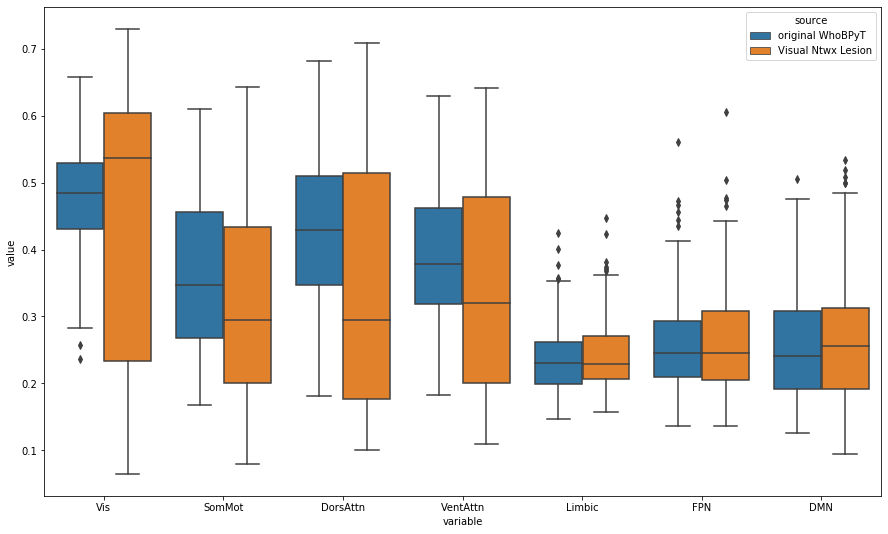

In [176]:
fig, ax = plt.subplots(figsize=(15,9))
ax = sns.boxplot(data=combined_df_long,x='variable',y='value',hue='source')


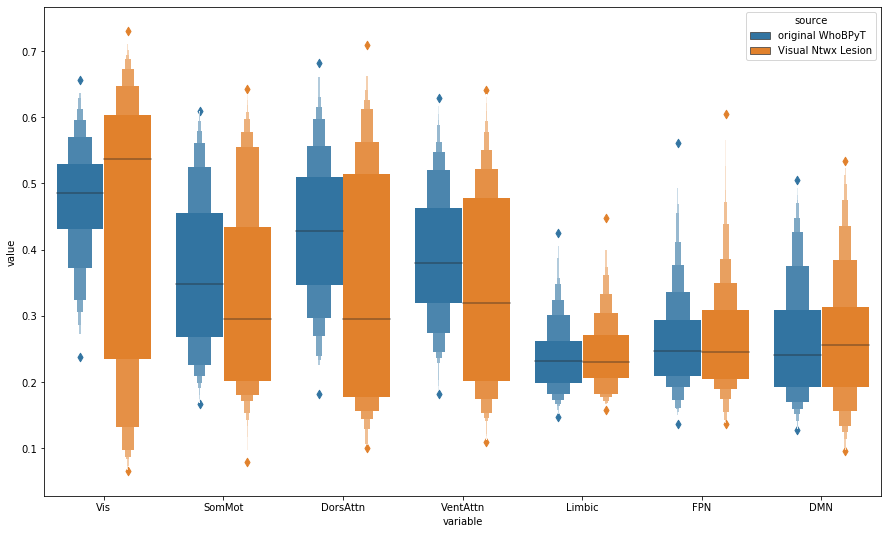

In [177]:
fig, ax = plt.subplots(figsize=(15,9))
sns.boxenplot(data=combined_df_long,x='variable',y='value',hue='source')

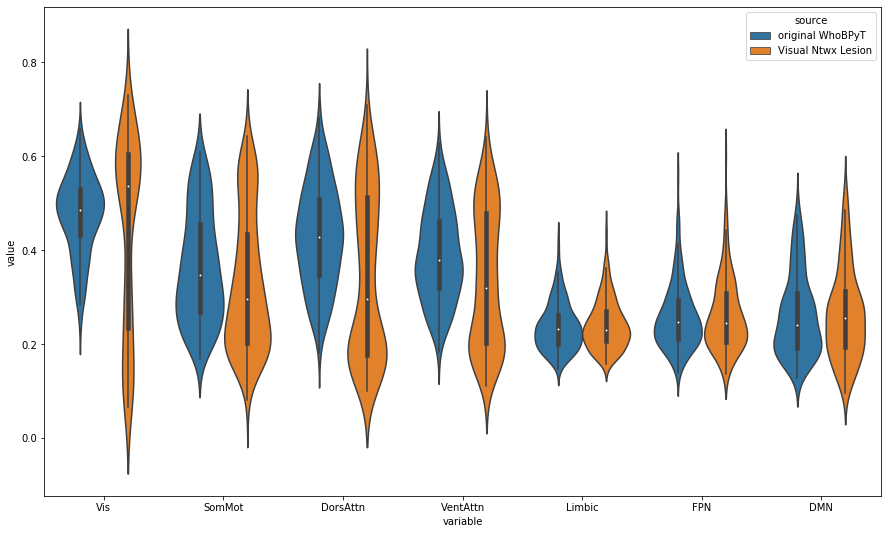

In [178]:
fig, ax = plt.subplots(figsize=(15,9))
sns.violinplot(data=combined_df_long,x='variable',y='value',hue='source')

In [62]:
# sns.violinplot(data=combined_df,hue='source')

# plt.show()


####  Visual

In [179]:
org_whobpyt_means

[0.4762078600105418,
 0.3631816538835267,
 0.42919435967509484,
 0.3896369001336325,
 0.23726664629058955,
 0.25749079527721935,
 0.2609094925186768]

In [180]:
org_whobpyt_means

[0.4762078600105418,
 0.3631816538835267,
 0.42919435967509484,
 0.3896369001336325,
 0.23726664629058955,
 0.25749079527721935,
 0.2609094925186768]

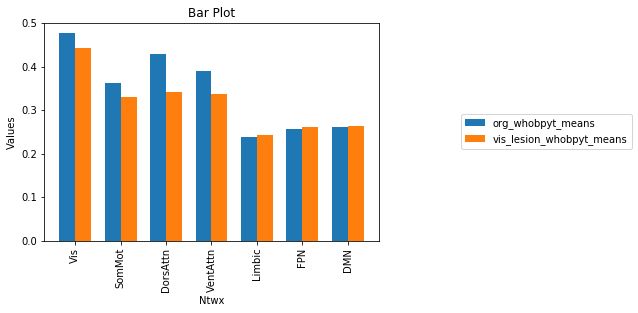

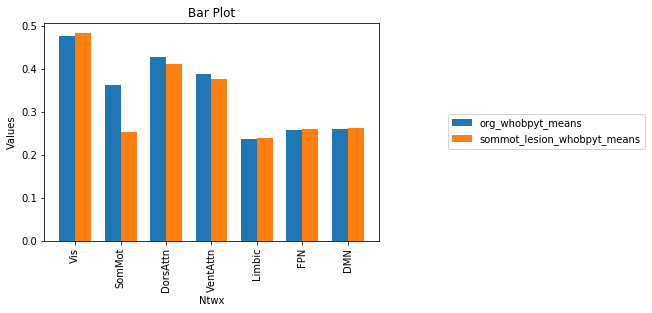

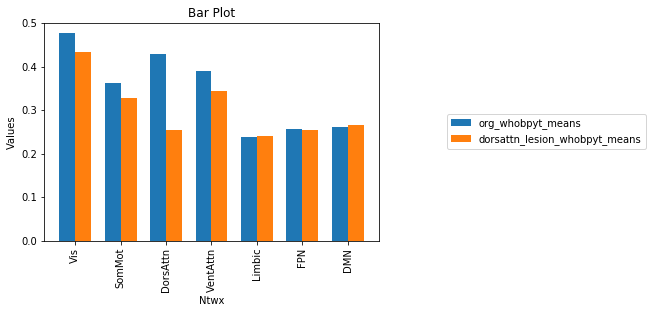

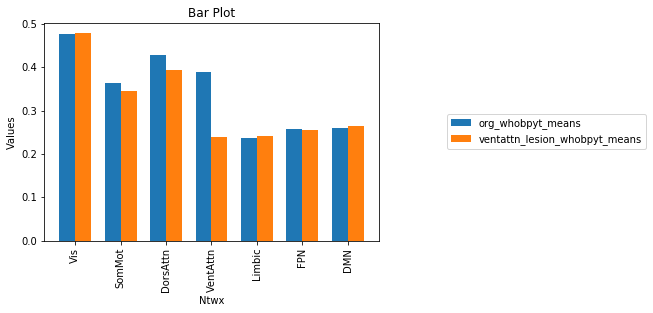

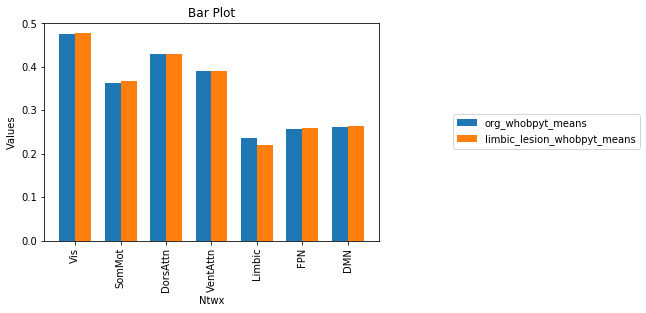

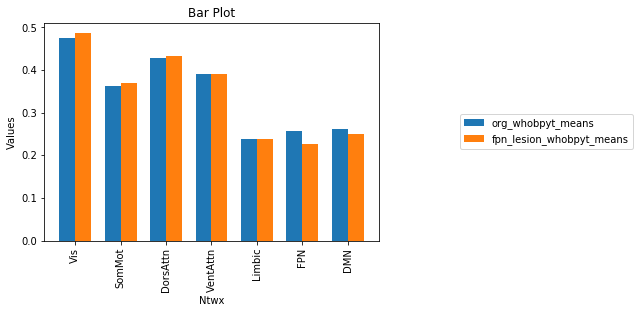

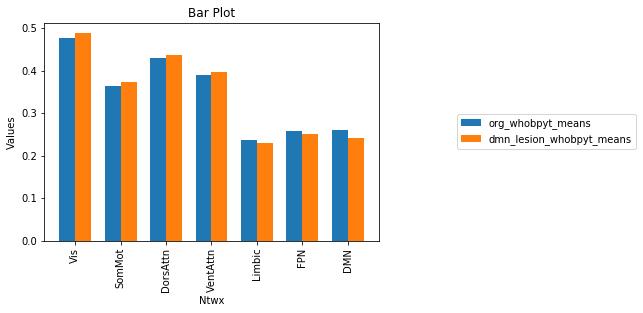

In [81]:
# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], vis_lesion_whobpyt_means, width, label='vis_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Sommot

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], sommot_lesion_whobpyt_means, width, label='sommot_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Dorsattn

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], dorsattn_lesion_whobpyt_means, width, label='dorsattn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Ventattn

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], ventattn_lesion_whobpyt_means, width, label='ventattn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### Limbic

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], limbic_lesion_whobpyt_means, width, label='limbic_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### FPN

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], fpn_lesion_whobpyt_means, width, label='fpn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

#### DMN lesion

# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], dmn_lesion_whobpyt_means, width, label='dmn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(bbox_to_anchor=[1.5, 0.5], loc='center')

# Displaying the plot
plt.show()

## -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

### With threshold (>0.1, etc)

In [182]:
def ntwx_only_fc_with_thresh(fc, sub, a,b,c,d):
    
    thresh = 0.1
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_lh = ntwx_only_lh[(ntwx_only_lh>thresh)]
    
    ntwx_only_rh = fc[sub][c:d, c:d]
    ntwx_only_rh = ntwx_only_rh[(ntwx_only_rh>thresh)]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_lhrh = ntwx_only_lhrh[(ntwx_only_lhrh>thresh)]
    
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    ntwx_only_rhlh = ntwx_only_rhlh[(ntwx_only_rhlh>thresh)]
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh))/2 + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2
    
    return mean_fc

In [183]:
%%time

# original whobpyt

org_whobpyt_vis_mean_fc_all_subs_thresh = []
org_whobpyt_sommot_mean_fc_all_subs_thresh = []
org_whobpyt_dorsattn_mean_fc_all_subs_thresh = []
org_whobpyt_ventattn_mean_fc_all_subs_thresh = []
org_whobpyt_limbic_mean_fc_all_subs_thresh = []
org_whobpyt_fpn_mean_fc_all_subs_thresh = []
org_whobpyt_dmn_mean_fc_all_subs_thresh = []

for i in range(200):
    
    temp_vis = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    org_whobpyt_vis_mean_fc_all_subs_thresh.append(temp_vis)
    
    temp_sommot = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    org_whobpyt_sommot_mean_fc_all_subs_thresh.append(temp_sommot)

    temp_dorsattn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    org_whobpyt_dorsattn_mean_fc_all_subs_thresh.append(temp_dorsattn)

    temp_ventattn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    org_whobpyt_ventattn_mean_fc_all_subs_thresh.append(temp_ventattn)

    temp_limbic = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    org_whobpyt_limbic_mean_fc_all_subs_thresh.append(temp_limbic)

    temp_fpn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    org_whobpyt_fpn_mean_fc_all_subs_thresh.append(temp_fpn)

    temp_dmn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    org_whobpyt_dmn_mean_fc_all_subs_thresh.append(temp_dmn)

    
    
    
org_whobpyt_vis_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_vis_mean_fc_all_subs_thresh, nan=0))
org_whobpyt_sommot_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_sommot_mean_fc_all_subs_thresh, nan=0))
org_whobpyt_dorsattn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_dorsattn_mean_fc_all_subs_thresh, nan=0))
org_whobpyt_ventattn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_ventattn_mean_fc_all_subs_thresh, nan=0))
# issue affected limbic ntwx only ...
# hence the custom fix ...
org_whobpyt_limbic_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_limbic_mean_fc_all_subs_thresh, nan=0))
org_whobpyt_fpn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_fpn_mean_fc_all_subs_thresh, nan=0))
org_whobpyt_dmn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_dmn_mean_fc_all_subs_thresh, nan=0))


org_whobpyt_means_with_thresh = [org_whobpyt_vis_mean_fc_all_subs_thresh_mean,
org_whobpyt_sommot_mean_fc_all_subs_thresh_mean,
org_whobpyt_dorsattn_mean_fc_all_subs_thresh_mean,
org_whobpyt_ventattn_mean_fc_all_subs_thresh_mean,
org_whobpyt_limbic_mean_fc_all_subs_thresh_mean,
org_whobpyt_fpn_mean_fc_all_subs_thresh_mean,
org_whobpyt_dmn_mean_fc_all_subs_thresh_mean]

CPU times: user 193 ms, sys: 0 ns, total: 193 ms
Wall time: 191 ms


In [184]:
org_whobpyt_means_with_thresh

[0.5899761997438923,
 0.5366749034271697,
 0.5642287565321218,
 0.5713466323107853,
 0.5869251824259143,
 0.588501091845982,
 0.5376091106626599]

In [185]:
# org_whobpyt_means_with_thresh

#### with thresh

In [186]:
def func_for_inner_ntwx_connectivity_with_thresh(all_subs_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 0, 14, 100, 115)
        ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 14, 30, 115, 134)
        ntwx_lesion_whobpyt_sommot_mean_fc_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 30, 43, 134, 147)
        ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 43, 54, 147, 158)
        ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 54, 60, 158, 164)
        ntwx_lesion_whobpyt_limbic_mean_fc_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 60, 73, 164, 181)
        ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 73, 100, 181, 200)
        ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(ntwx_lesion_temp_dmn)


    ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_vis_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_sommot_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_limbic_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_fpn_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_dmn_mean_fc_all_subs, nan=0))


    ntwx_lesion_whobpyt_means = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means

In [187]:
#     ntwx_lesion_means_all_subs = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs,ntwx_lesion_whobpyt_sommot_mean_fc_all_subs,
#                                   ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs,ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs,
#                                   ntwx_lesion_whobpyt_limbic_mean_fc_all_subs,ntwx_lesion_whobpyt_fpn_mean_fc_all_subs,
#                                   ntwx_lesion_whobpyt_dmn_mean_fc_all_subs]

In [188]:
%%time
vis_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_vis_lesion)
sommot_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_sommot_lesion)
dorsattn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_dorsattn_lesion)
ventattn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_ventattn_lesion)
limbic_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_limbic_lesion)
fpn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_fpn_lesion)
dmn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_dmn_lesion)

CPU times: user 1.4 s, sys: 0 ns, total: 1.4 s
Wall time: 1.4 s


### With threshold (>0.1) figures

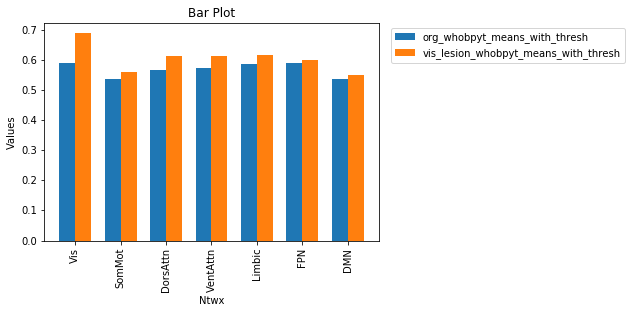

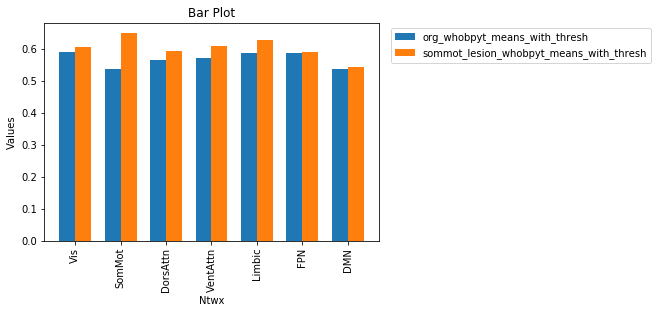

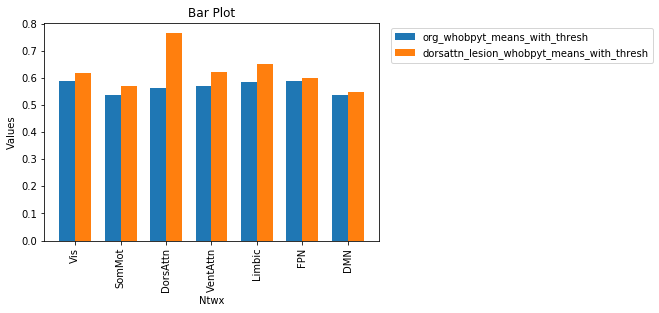

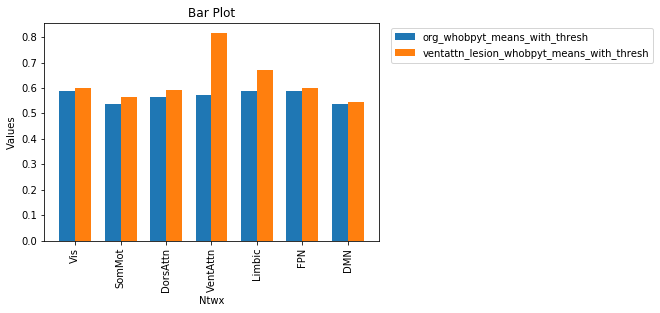

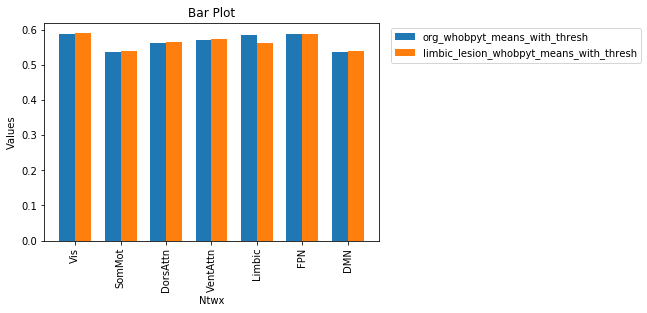

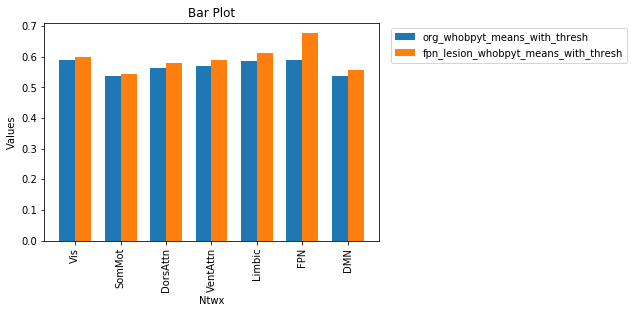

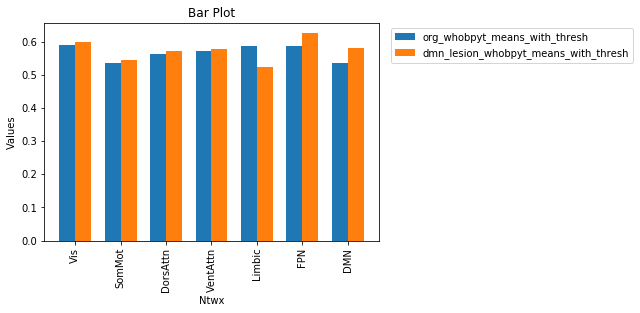

In [189]:
# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], vis_lesion_whobpyt_means_with_thresh, width, label='vis_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

#### Sommot

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], sommot_lesion_whobpyt_means_with_thresh, width, label='sommot_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

#### Dorsattn

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], dorsattn_lesion_whobpyt_means_with_thresh, width, label='dorsattn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### Ventattn

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], ventattn_lesion_whobpyt_means_with_thresh, width, label='ventattn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### Limbic

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], limbic_lesion_whobpyt_means_with_thresh, width, label='limbic_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()



#### FPN

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], fpn_lesion_whobpyt_means_with_thresh, width, label='fpn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### DMN lesion

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], dmn_lesion_whobpyt_means_with_thresh, width, label='dmn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

# -------------------------------------------------------------------------------

### Negative Correlations only (with thresh)

In [190]:
def ntwx_only_fc_with_thresh_negative(fc, sub, a,b,c,d):
    
    thresh = -0.05
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_lh = ntwx_only_lh[(ntwx_only_lh<thresh)]
    
    ntwx_only_rh = fc[sub][c:d, c:d]
    ntwx_only_rh = ntwx_only_rh[(ntwx_only_rh<thresh)]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_lhrh = ntwx_only_lhrh[(ntwx_only_lhrh<thresh)]
    
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    ntwx_only_rhlh = ntwx_only_rhlh[(ntwx_only_rhlh<thresh)]
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh))/2 + (np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/2
    
    return mean_fc

In [191]:
%%time

# original whobpyt

neg_org_whobpyt_vis_mean_fc_all_subs_thresh = []
neg_org_whobpyt_sommot_mean_fc_all_subs_thresh = []
neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh = []
neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh = []
neg_org_whobpyt_limbic_mean_fc_all_subs_thresh = []
neg_org_whobpyt_fpn_mean_fc_all_subs_thresh = []
neg_org_whobpyt_dmn_mean_fc_all_subs_thresh = []

for i in range(200):
    
    temp_vis = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    neg_org_whobpyt_vis_mean_fc_all_subs_thresh.append(temp_vis)
    
    temp_sommot = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    neg_org_whobpyt_sommot_mean_fc_all_subs_thresh.append(temp_sommot)

    temp_dorsattn = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh.append(temp_dorsattn)

    temp_ventattn = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh.append(temp_ventattn)

    temp_limbic = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    neg_org_whobpyt_limbic_mean_fc_all_subs_thresh.append(temp_limbic)

    temp_fpn = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    neg_org_whobpyt_fpn_mean_fc_all_subs_thresh.append(temp_fpn)

    temp_dmn = ntwx_only_fc_with_thresh_negative(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    neg_org_whobpyt_dmn_mean_fc_all_subs_thresh.append(temp_dmn)

    
    
    
neg_org_whobpyt_vis_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_vis_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_sommot_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_sommot_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_limbic_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_limbic_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_fpn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_fpn_mean_fc_all_subs_thresh, nan=0))
neg_org_whobpyt_dmn_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(neg_org_whobpyt_dmn_mean_fc_all_subs_thresh, nan=0))


neg_org_whobpyt_means_with_thresh = [neg_org_whobpyt_vis_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_sommot_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_limbic_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_fpn_mean_fc_all_subs_thresh_mean,
neg_org_whobpyt_dmn_mean_fc_all_subs_thresh_mean]

CPU times: user 217 ms, sys: 0 ns, total: 217 ms
Wall time: 215 ms


In [192]:
neg_org_whobpyt_means_with_thresh

[-0.03645037422902771,
 -0.056106755219903964,
 -0.029601948956776578,
 -0.024436710181501703,
 -0.048706069518529876,
 -0.09854975768725996,
 -0.11708481964529717]

In [193]:
neg_org_whobpyt_vis_mean_fc_all_subs_thresh_mean

-0.03645037422902771

In [194]:
print(np.nanmin(neg_org_whobpyt_vis_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_sommot_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_dorsattn_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_ventattn_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_limbic_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_fpn_mean_fc_all_subs_thresh))
print(np.nanmin(neg_org_whobpyt_dmn_mean_fc_all_subs_thresh))

-0.163018300053209
-0.15289359667581487
-0.19252512813482997
-0.16516943290894887
-0.18122573961857502
-0.17260037529002803
-0.14930517977258503


In [195]:
def func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_neg_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    neg_ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_sommot_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_limbic_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    neg_ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        neg_ntwx_lesion_temp_vis = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 0, 14, 100, 115)
        neg_ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(neg_ntwx_lesion_temp_vis)

        neg_ntwx_lesion_temp_sommot = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 14, 30, 115, 134)
        neg_ntwx_lesion_whobpyt_sommot_mean_fc_all_subs.append(neg_ntwx_lesion_temp_sommot)

        neg_ntwx_lesion_temp_dorsattn = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 30, 43, 134, 147)
        neg_ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs.append(neg_ntwx_lesion_temp_dorsattn)

        neg_ntwx_lesion_temp_ventattn = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 43, 54, 147, 158)
        neg_ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs.append(neg_ntwx_lesion_temp_ventattn)

        neg_ntwx_lesion_temp_limbic = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 54, 60, 158, 164)
        neg_ntwx_lesion_whobpyt_limbic_mean_fc_all_subs.append(neg_ntwx_lesion_temp_limbic)

        neg_ntwx_lesion_temp_fpn = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 60, 73, 164, 181)
        neg_ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(neg_ntwx_lesion_temp_fpn)

        neg_ntwx_lesion_temp_dmn = ntwx_only_fc_with_thresh_negative(all_subs_neg_ntwx_lesion, i, 73, 100, 181, 200)
        neg_ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(neg_ntwx_lesion_temp_dmn)


    neg_ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_vis_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_sommot_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_limbic_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_fpn_mean_fc_all_subs, nan=0))
    
    neg_ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(neg_ntwx_lesion_whobpyt_dmn_mean_fc_all_subs, nan=0))


    neg_ntwx_lesion_whobpyt_means = [neg_ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    neg_ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return neg_ntwx_lesion_whobpyt_means

In [196]:
%%time
neg_vis_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_vis_lesion)
neg_sommot_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_sommot_lesion)
neg_dorsattn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_dorsattn_lesion)
neg_ventattn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_ventattn_lesion)
neg_limbic_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_limbic_lesion)
neg_fpn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_fpn_lesion)
neg_dmn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh_negative(all_subs_dmn_lesion)

CPU times: user 1.48 s, sys: 49.1 ms, total: 1.53 s
Wall time: 1.53 s


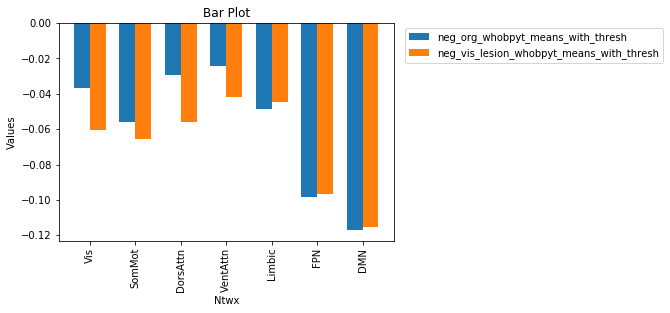

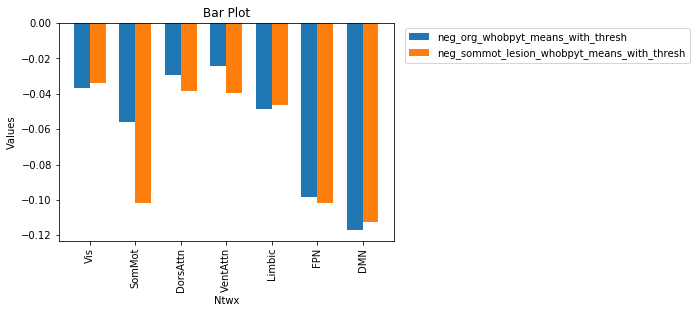

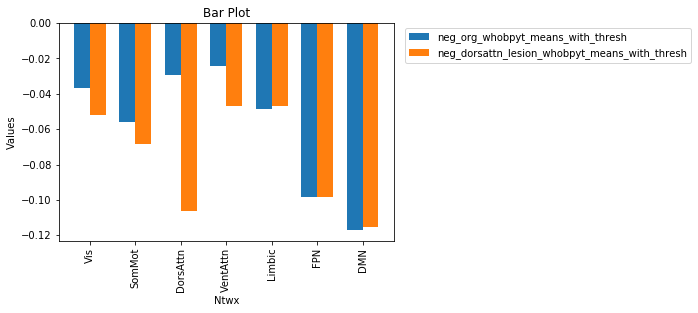

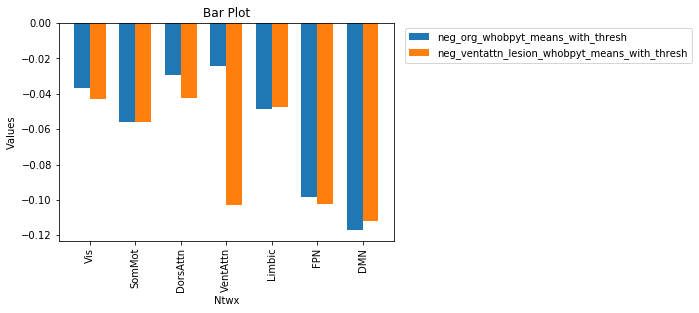

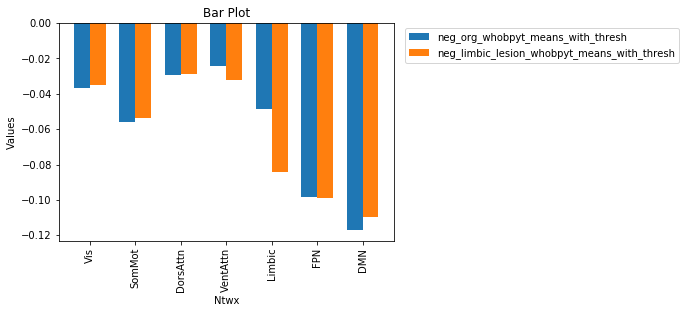

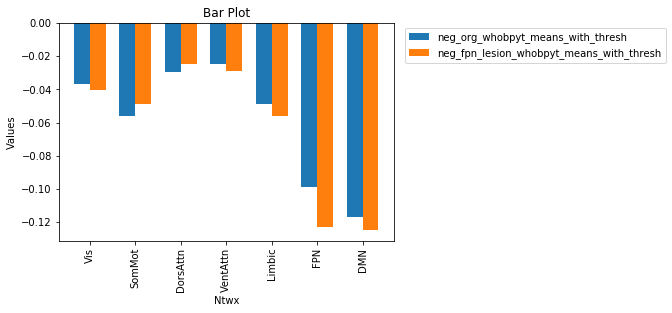

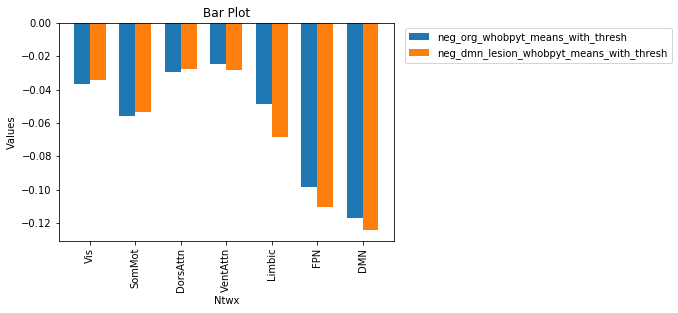

In [197]:
# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_vis_lesion_whobpyt_means_with_thresh, width, label='neg_vis_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

#### Sommot

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_sommot_lesion_whobpyt_means_with_thresh, width, label='neg_sommot_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

#### Dorsattn

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_dorsattn_lesion_whobpyt_means_with_thresh, width, label='neg_dorsattn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### Ventattn

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_ventattn_lesion_whobpyt_means_with_thresh, width, label='neg_ventattn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### Limbic

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_limbic_lesion_whobpyt_means_with_thresh, width, label='neg_limbic_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()



#### FPN

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_fpn_lesion_whobpyt_means_with_thresh, width, label='neg_fpn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### DMN lesion

# Creating the bar plot
x = range(len(neg_org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, neg_org_whobpyt_means_with_thresh, width, label='neg_org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], neg_dmn_lesion_whobpyt_means_with_thresh, width, label='neg_dmn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

In [ ]:
# Next step: re-introduce sc for each of the other networks 